In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import scipy.stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import urllib
import requests
import zipfile
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
import geopandas as gpd

Populating the interactive namespace from numpy and matplotlib


pluto data

In [60]:
for br in ['bx','bk','mn','qn','si']:
    urllib.urlretrieve('https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/{}_mappluto_16v2.zip'.format(br),
                       '{}.zip'.format(br))
    file = zipfile.ZipFile('{}.zip'.format(br))
    file.extractall()

In [61]:
urllib.urlretrieve('https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'
                  ,'nyc_zip.zip')
file = zipfile.ZipFile('nyc_zip.zip')
file.extractall()

In [62]:
!dir

BK_Dcp_Mappinglot.dbf	   bx_pluto.dbf		      QNMapPLUTO.sbx
BK_Dcp_Mappinglot.prj	   bx_pluto.dbf.xml	      QNMapPLUTO.shp
BK_Dcp_Mappinglot.sbn	   bx.zip		      QNMapPLUTO.shp.xml
BK_Dcp_Mappinglot.sbx	   MN_Dcp_Mappinglot.dbf      QNMapPLUTO.shx
BK_Dcp_Mappinglot.shp	   MN_Dcp_Mappinglot.prj      QNMapPLUTO.ZoneDist1.atx
BK_Dcp_Mappinglot.shp.xml  MN_Dcp_Mappinglot.sbn      qn_pluto.dbf
BK_Dcp_Mappinglot.shx	   MN_Dcp_Mappinglot.sbx      qn_pluto.dbf.xml
BKMapPLUTO.BBL.atx	   MN_Dcp_Mappinglot.shp      qn.zip
BKMapPLUTO.CD.atx	   MN_Dcp_Mappinglot.shp.xml  README.md
BKMapPLUTO.dbf		   MN_Dcp_Mappinglot.shx      SI_Dcp_Mappinglot.dbf
BKMapPLUTO.LandUse.atx	   MNMapPLUTO.BBL.atx	      SI_Dcp_Mappinglot.prj
BKMapPLUTO.prj		   MNMapPLUTO.CD.atx	      SI_Dcp_Mappinglot.sbn
BKMapPLUTO.sbn		   MNMapPLUTO.dbf	      SI_Dcp_Mappinglot.sbx
BKMapPLUTO.sbx		   MNMapPLUTO.LandUse.atx     SI_Dcp_Mappinglot.shp
BKMapPLUTO.shp		   MNMapPLUTO.prj	      SI_Dcp_Mappinglot.shp.xml
BKMapPLUTO.shp.xml	   M

income data

In [63]:
def get_income(url):
    incomeByZip = pd.read_excel(url,header=3,index_col='ZIP\ncode [1]')
    incomeByZip.rename(columns={'Adjusted gross income (AGI) [3]':'Adjusted gross income (AGI)',
                                'Adjusted gross income (AGI) [2]':'Adjusted gross income (AGI)'},inplace=True)
    zipincome = pd.DataFrame()
    for i in incomeByZip.index.unique():
        if i is np.nan: continue
        elif type(incomeByZip.loc[i]["Adjusted gross income (AGI)"]) is np.float64: continue
        else:
            zipincome.loc[i,'income'] = incomeByZip.loc[i]["Adjusted gross income (AGI)"].iloc[0]
            zipincome.loc[i,'N'] = incomeByZip.loc[i]["Number of returns"].iloc[0]
            zipincome.loc[i,'Ndepend'] = incomeByZip.loc[i]["Number of dependents"].iloc[0]
            zipincome.loc[i,'Njoint'] = incomeByZip.loc[i]["Number of joint returns"].iloc[0]
    zipincome['income'] = zipincome.loc[:,'income']
    zipincome['Pop'] = (zipincome.loc[:,'N'] + zipincome.loc[:,'Ndepend'] + zipincome.loc[:,'Njoint'])
    zipincome = zipincome[['income','Pop']]
    return zipincome

In [64]:
income_14 = get_income('http://www.nber.org/tax-stats/zipcode/2014/14zp33ny.xls')

In [65]:
Income = (income_14).dropna(axis=0)

In [66]:
Income = Income.reset_index().rename(columns={'index':'Zip'})

In [67]:
Income.Zip = Income.Zip.astype('str')
Income.head()

,Zip,income,Pop
0,0,766646080.0,17879420.0
1,10001,2363960.0,19740.0
2,10002,2215542.0,73570.0
3,10003,6910992.0,40060.0
4,10004,925417.0,4510.0


So now we have the predicted 2016 asthma hospital discharge rate for some Zipcode areas

In [68]:
nyc = gpd.GeoDataFrame.from_file('ZIP_CODE_040114.shp')

In [69]:
nyc.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [70]:
nyc1 = nyc.merge(Income,left_on='ZIPCODE',right_on='Zip',how='outer')

In [82]:
nyc1.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,Zip,income,Pop
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",11436,350170.0,17590.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",11213,1056625.0,55450.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",11212,1102320.0,72340.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",11225,1301298.0,52470.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",11218,1749837.0,72560.0


In [72]:
nyc1.columns

Index([   u'ZIPCODE',    u'BLDGZIP',    u'PO_NAME', u'POPULATION',
             u'AREA',      u'STATE',     u'COUNTY',    u'ST_FIPS',
         u'CTY_FIPS',        u'URL', u'SHAPE_AREA',  u'SHAPE_LEN',
         u'geometry',        u'Zip',     u'income',        u'Pop'],
      dtype='object')

In [84]:
nyc1.income = nyc1.income.fillna(0)
nyc1.income = nyc1.income.astype('str')

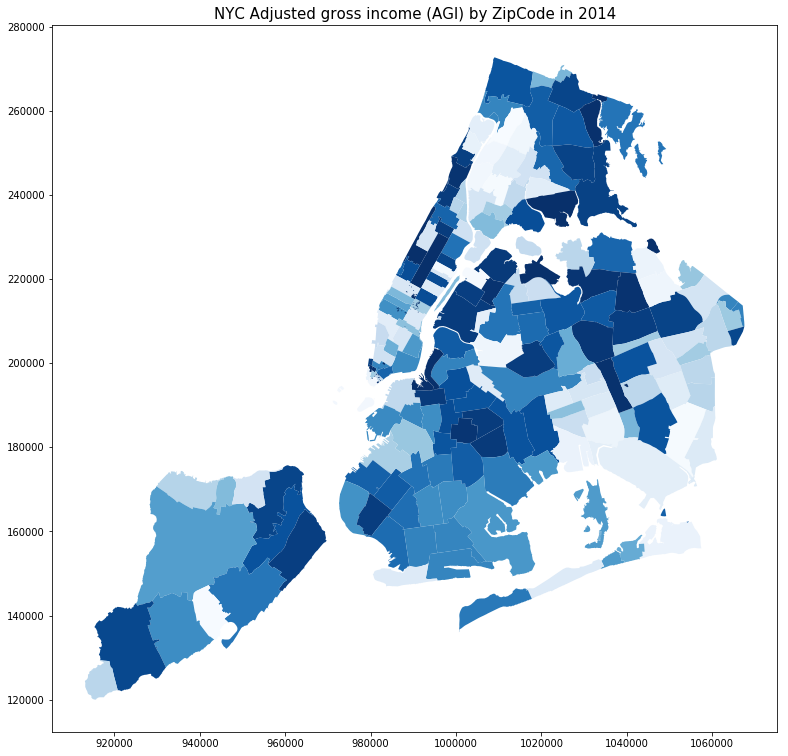

In [95]:
fig = plt.figure(figsize=[13,13])
ax = fig.add_subplot(111)
nyc1.plot(column='income', cmap='Blues_r',ax=ax,alpha=1)
ax.set_title('NYC Adjusted gross income (AGI) by ZipCode in 2014',size=15)